In [5]:
%matplotlib notebook

import sys
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os

sys.path.append("../DesignTool")
from smdtLibs.configFile import ConfigFile
from targets import TargetList
from smdtLibs.inOutChecker import InOutChecker
from maskDesignFile import (
    MaskDesignInputFitsFile,
    MaskDesignOutputFitsFile,
    outputAsList,
)
from maskLayouts import MaskLayouts, GuiderFOVs, shrinkMask
from smdtLibs import utils, drawUtils, DARCalculator
from astropy.modeling import models, fitting

import glob

from Test_All import Test_Inputs

sys.path.append("/home/kalahuipuaa/skwok/hq/data/libs/")
import LevMarqFitter

<IPython.core.display.Javascript object>

In [2]:
try:
    %load_ext nb_black
except:
    print("Ignore extension nb_black")
    pass

<IPython.core.display.Javascript object>

In [3]:
prefix = "../DeimosExamples/Examples2/"

<IPython.core.display.Javascript object>

In [4]:
config_fname = "../DesignTool/smdt.cfg"
param_fname = "../DesignTool/params.cfg"

config = ConfigFile(config_fname)
config.properties["params"] = ConfigFile(param_fname)


<IPython.core.display.Javascript object>

### Compare PNT center with calculated center

- Read PNT center from MDF file
- Read center from out file
- Put results in array and create a data frame

In [18]:
out = []
for k, v in Test_Inputs.items():
    fitsName, CenRa, CenDec, Angle, lst, flag = v
    mdf = MaskDesignInputFitsFile(fitsName)
    pntRa, pntDec, pntPa = mdf.getPNTCenter()
    maskRa, maskDec, maskPa = mdf.pntCen2MaskCenter(config)
    CenRa, CenDec = utils.sexg2Float(CenRa) * 15, utils.sexg2Float(CenDec)
    out.append((pntPa, pntRa, pntDec, CenRa, CenDec, maskRa, maskDec))

df = pd.DataFrame(
    out, columns=("PntPa", "PntRa", "PntDec", "CenRa", "CenDec", "maskRa", "maskDec")
)

<IPython.core.display.Javascript object>

In [19]:
df

,PntPa,PntRa,PntDec,CenRa,CenDec,maskRa,maskDec
0,106.0,152.085897,12.246817,152.119375,12.315556,152.106570,12.320590
1,50.0,114.593027,38.792944,114.538333,38.853333,114.544817,38.866657
2,-52.0,31.342009,-4.189464,31.292917,-4.253194,31.295835,-4.248723
3,0.0,247.455012,0.914620,247.380000,0.911000,247.380012,0.914620
4,105.0,247.360589,0.842175,247.380000,0.911000,247.380000,0.914627
5,120.0,247.342498,0.849667,247.380000,0.911000,247.379998,0.914626
6,135.0,247.326963,0.861586,247.380000,0.911000,247.379996,0.914625
7,15.0,247.452456,0.895208,247.380000,0.911000,247.380012,0.914622
8,150.0,247.315043,0.877119,247.380000,0.911000,247.379994,0.914624
9,165.0,247.307549,0.895208,247.380000,0.911000,247.379994,0.914622


<IPython.core.display.Javascript object>

In [7]:
def model (xys, x0, y0, r0):
    xs, ys = xys
    s = xs**2 - 2.0 * xs * x0 + x0**2 + ys**2 - 2.0 * ys *y0 + y0**2 - r0 ** 2
    return np.sqrt(np.dot (s, s))
    
xs = np.array(list(zip(df.PntRa, df.PntDec))).T
ys = np.zeros_like(df.PntRa)
initParms = (cenx, ceny, 300.0/3600)

lmf = LevMarqFitter.LevMarqFitter(tol=1E-8, debug=False)
results = lmf.fit(xs, ys, initParms, model)


<IPython.core.display.Javascript object>

In [8]:
results[2] * 3600

270.04100818321706

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


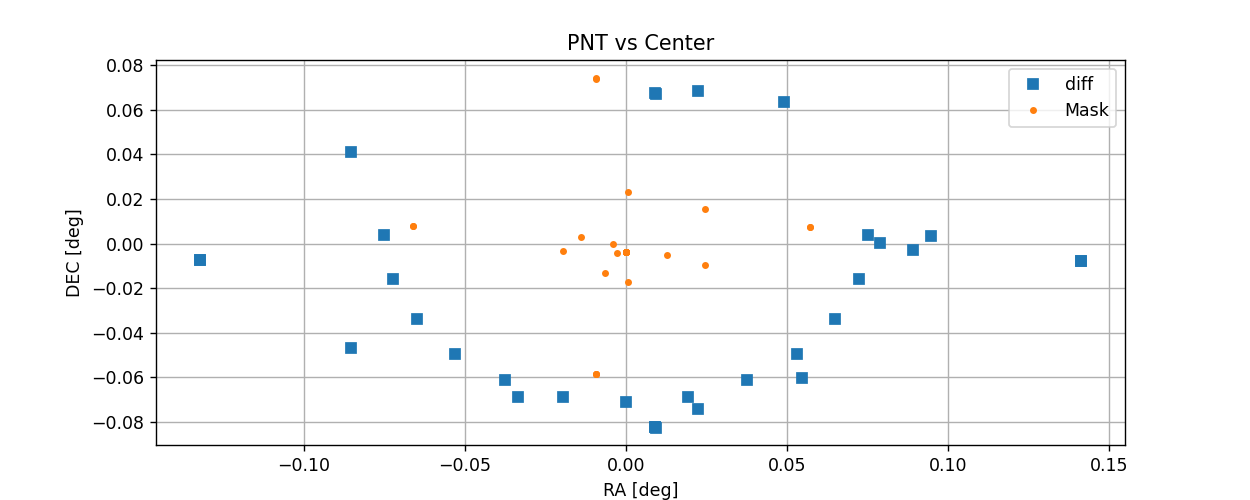

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(df.PntRa - df.CenRa, df.PntDec - df.CenDec, "s", label="diff")
plt.plot(df.CenRa - df.maskRa, df.CenDec - df.maskDec, ".", label="Mask")

plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.legend()
plt.title("PNT vs Center")
plt.grid()

In [10]:
(ceny - results[1]) * 3600

-13.067049606494185

<IPython.core.display.Javascript object>

In [11]:
# Given a center (cx, cy)
# Calculates the PNT center

atRefr = DARCalculator.DARCalculator(
    config.properties["tellatitude"],
    config.properties["referencewavelen"] * 1000,
    615,
    0,
)

out = []
for f in glob.glob(prefix + "/*.fits"):
    mdf = MaskDesignInputFitsFile(f)
    pntRaDeg, pntDecDeg, pntPaDeg = mdf.getPNTCenter()

    tlist = TargetList(f.replace(".fits", ".out"), config=config)
    ra1, dec1 = tlist.toPNTCenter(pntPaDeg, mdf.maskdesign.LST_PNT[0])
    ra2, dec2 = np.degrees((tlist.telRaRad, tlist.telDecRad))
    # ra2, dec2 = mdf.getRotationCenter(config)
    out.append((f, pntRaDeg, pntDecDeg, ra1, dec1, ra2, dec2, pntPaDeg))

<IPython.core.display.Javascript object>

In [12]:
outT = [np.array(x) for x in zip(*out)]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


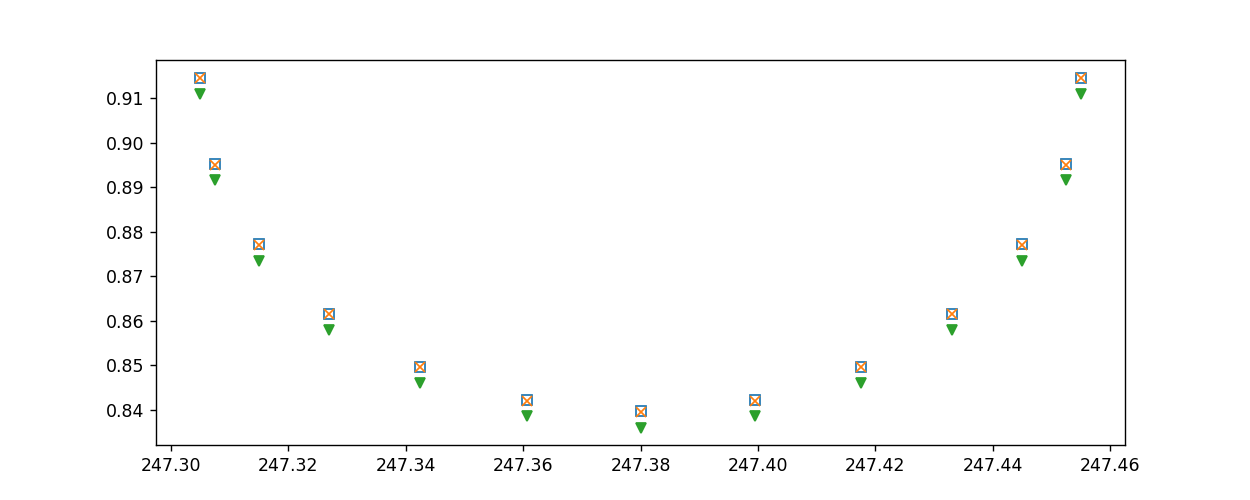

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(outT[1], outT[2], "s", mfc="None")
plt.plot(outT[3], outT[4], "x")
plt.plot(outT[5], outT[6], "v")

# dists = np.hypot(outT[1] - outT[3], outT[2] - outT[4]) * 3600
# plt.plot(outT[1], (outT[2] - outT[4]) * 3600, "x")

In [14]:
for n, a, b, c, d, e, f, g in out:
    print(c - e, (d - f) * 3600, g)

2.7180387576208886e-06 12.53122269447382 0.0
2.712949537908571e-06 12.531983022841686 30.0
2.6693938934840844e-06 12.533854431035296 75.0
2.704346485415954e-06 12.532682213667723 45.0
2.645426292247066e-06 12.534032686283858 90.0
2.689767512720209e-06 12.533363577006673 60.0
2.7169509451141494e-06 12.531448167957704 15.0
2.621458691010048e-06 12.533854431034896 105.0
2.577903018163852e-06 12.531983022841287 150.0
2.601085071773923e-06 12.533363577006673 120.0
2.586506070656469e-06 12.532682213667723 135.0
2.5728138268732437e-06 12.53122269447382 180.0
2.5739016109582735e-06 12.531448167957704 165.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


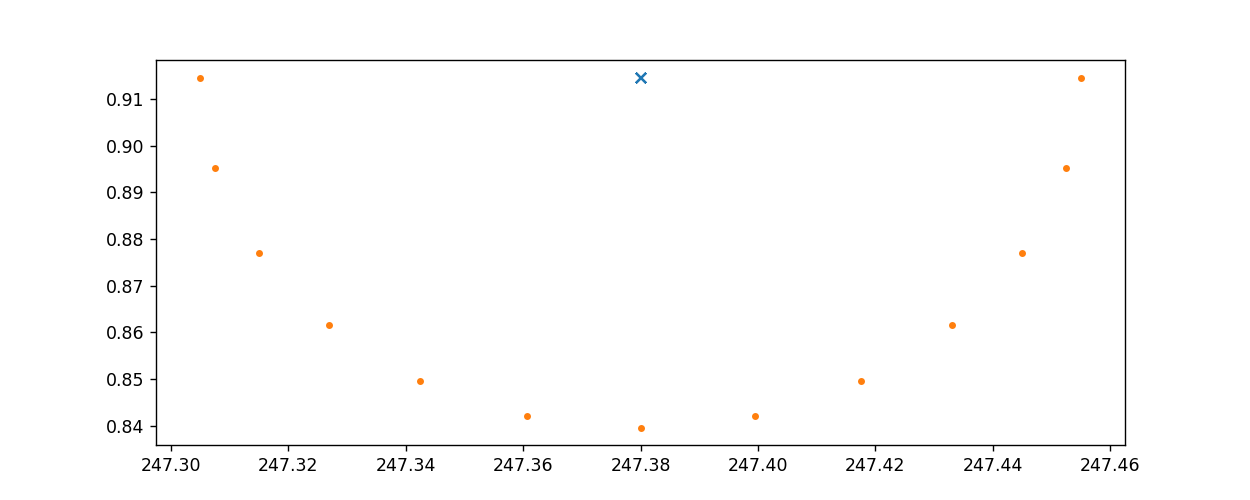

<IPython.core.display.Javascript object>

In [15]:
# pntCen2MaskCenter
# outT[1] = pntRa
# outT[2] = pntDec
# outT[7] = paDeg
pntX, pntY = config.properties["fldcenx"], config.properties["fldceny"]

x1, y1 = utils.rotate(pntX, -pntY, -outT[7] - 90)
cosd = np.cos(np.radians(outT[2]))

y1 = y1 / cosd
vx1, vy1 = outT[1] + x1 / 3600, outT[2] + y1 / 3600

plt.figure(figsize=(10, 4))
plt.plot(vx1, vy1, "x")

plt.plot(outT[1], outT[2], ".")
# plt.plot(x1, y1, "+")